In [1]:
# packages and libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from imutils import paths
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM,GRU, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import backend as K

In [2]:
def getUnreadableCount(df):
    return (df['IDENTITY'] == 'UNREADABLE').sum();

def getLowercaseCount(df):
    return (df['IDENTITY'].str.islower()).sum();

def getDigitCount(df):
    return (df['IDENTITY'].str.isdigit()).sum();
  
def removeUnreadableEntries(df):
    is_unreadable = df['IDENTITY'] != 'UNREADABLE';
    df = df[is_unreadable];
    return df;

def removeDigitEntries(df):
    is_digit = df['IDENTITY'].str.isdigit();
    df = df[is_digit];
    return df;

def cleanDataSet(df):
    empty_count = df.isnull().sum().sum();
    if(empty_count):
        df.dropna(inplace=True);
    unreadable_count = getUnreadableCount(df);
    if(unreadable_count):
        df = removeUnreadableEntries(df);
    digit_count = getDigitCount(df);          
    if(digit_count):
        df = removeDigitEntries(df);
    lowercase_count = getLowercaseCount(df);
    if(lowercase_count):
        # Names in the pictures are all uppercase, we have to make our data uppercase
        df.loc[:, 'IDENTITY'] = df['IDENTITY'].apply(lambda x: x.upper());
    notpicture_count = df[~df["FILENAME"].str.endswith('.jpg')].sum().sum().astype(int);
    if(notpicture_count):                       # 0 for train, 0 for validation
         df = df[df["FILENAME"].str.contains('.jpg')];
    return df;

def num_to_char(num): 
    label = ""
    for ch in num:
        if ch == -1:
            break
            
        label+=alphabet_characters[ch]        
    return label

def ctc_loss_function(args):  
    y_pred, y_true, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [3]:
train_size = 50000
valid_size= 10000
alphabet_characters = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
num_of_characters = len(alphabet_characters) + 1
num_of_timestamps = 64

In [4]:
training_written_df = pd.read_csv('D:/Thirumalai/32053/RCNN&GRU/written_name_train_v2.csv')
validation_written_df = pd.read_csv('D:/Thirumalai/32053/RCNN&GRU/written_name_validation_v2.csv')

In [5]:
training_written_df


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


In [6]:
validation_written_df

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
...,...,...
41365,VALIDATION_41366.jpg,CHAILLAN
41366,VALIDATION_41367.jpg,BAROUH
41367,VALIDATION_41368.jpg,MAXENCE
41368,VALIDATION_41369.jpg,HAMELIN


# Data Cleaning

In [7]:
training_written_df = cleanDataSet(training_written_df);
validation_written_df = cleanDataSet(validation_written_df);
    

training_written_df.reset_index(inplace = True, drop=True)
validation_written_df.reset_index(inplace = True, drop=True) 

# Example of picture after resizing to 128x64 and 256x32

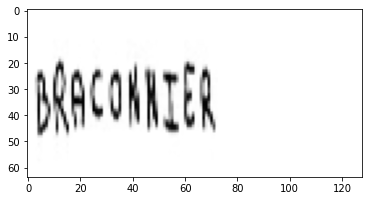

In [8]:
i = 128;
img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (128, 64))
plt.imshow(new_img, cmap = 'gray')
plt.show()

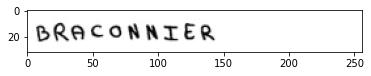

In [9]:
i = 128;
img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[i, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
new_img = cv2.resize(image, (256, 32))
plt.imshow(new_img, cmap = 'gray')
plt.show()

# Data preparation

In [17]:
valid_x = []
for i in range(valid_size):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/validation/'+validation_written_df.loc[i, 'FILENAME']   
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    valid_x.append(image)
    
train_x = []
for j in range(train_size):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/train/'+training_written_df.loc[j, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    train_x.append(image)

In [18]:
valid_x = np.array(valid_x).reshape(-1, 256, 32, 1)
train_x = np.array(train_x).reshape(-1, 256, 32, 1)

str_len = training_written_df["IDENTITY"].str.len().max()

In [19]:
train_y = np.ones([train_size, str_len]) * -1

train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

valid_y = np.ones([valid_size, str_len]) * -1

valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

# Label preparation

In [20]:
for i in range(train_size):
    label = []
    for ch in training_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    train_y[i, 0:len(training_written_df.loc[i, 'IDENTITY'])] = arr;
    train_label_len[i] = len(training_written_df.loc[i, 'IDENTITY'])


for i in range(valid_size):
    label = []
    for ch in validation_written_df['IDENTITY'][i]:
        label.append(alphabet_characters.index(ch))
    arr = np.array(label)
    valid_y[i, 0:len(validation_written_df.loc[i, 'IDENTITY'])] = arr;
    valid_label_len[i] = len(validation_written_df.loc[i, 'IDENTITY'])

# CNN & GRU Proposed model

In [22]:
input_data = Input(shape=(256, 32, 1))

cnn_layer = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)  
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
    
cnn_layer = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)
    
cnn_layer = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(1, 1))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)

cnn_layer = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Activation('relu')(cnn_layer)
cnn_layer = MaxPooling2D(pool_size=(2, 2))(cnn_layer)
cnn_layer = Dropout(0.3)(cnn_layer)
    
# CNN to RNN
reshaped_layer = Reshape(target_shape=((64, 1024)))(cnn_layer)
dense_layer = Dense(64, activation='relu', kernel_initializer='he_normal')(reshaped_layer)
    
## RNN
rnn_layer = Bidirectional(GRU(256, return_sequences=True))(dense_layer)
rnn_layer = Bidirectional(GRU(256, return_sequences=True))(rnn_layer)
    
## OUTPUT
final_dense_layer = Dense(num_of_characters, kernel_initializer='he_normal')(rnn_layer)
y_pred = Activation('softmax')(final_dense_layer)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 32, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 32, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 32, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 32, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 16, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 16, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 16, 64)       256   

# Early Stopping Function


In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
]

# Calculation of CTC Loss Function

In [37]:
true_labels = Input(shape=[str_len], dtype='float32')
input_length = Input(shape=[1], dtype='int64')
label_length = Input(shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_loss_function, output_shape=(1,), name='ctc_loss')([y_pred, true_labels, input_length, label_length])
model_final = Model(inputs=[input_data, true_labels, input_length, label_length], outputs=ctc_loss)

# Compling Model

In [38]:
model_final.compile(loss={'ctc_loss' : lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

# Training of model

In [39]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=3, batch_size=64, callbacks=my_callbacks)

Epoch 1/3
782/782 [==============================] - 2268s 3s/step - loss: 3.9716 - val_loss: 3.4560
Epoch 2/3
782/782 [==============================] - 2847s 4s/step - loss: 3.2711 - val_loss: 2.7211
Epoch 3/3
782/782 [==============================] - 4021s 5s/step - loss: 2.8191 - val_loss: 2.4148


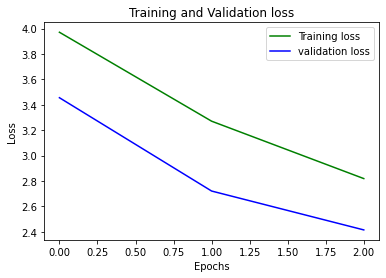

In [43]:
loss_train = np.array(history.history['loss'])
loss_val = np.array(history.history['val_loss'])
epochs = range(3)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using the decoding function from Keras

In [44]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for i in range(valid_size):
        output_text.append(num_to_char(K.get_value(results[i])))
    return output_text

In [45]:
model_valid_prediction = model.predict(valid_x)
decoded_valid_prediction = decode_batch_predictions(model_valid_prediction)

In [46]:
valid_true_labels = validation_written_df.loc[0:valid_size, 'IDENTITY']
correct = 0

for i in range(valid_size):
    pr = decoded_valid_prediction[i]
    tr = valid_true_labels[i]
    
    if pr == tr :
        correct += 1 
    
print('Correct words in validation predicted: %.2f%%' %(correct*100/valid_size))

Correct words in validation predicted: 61.04%


# Loading, cleaning and prediction on the test set

In [47]:
test_written_df = pd.read_csv('D:/Thirumalai/32053/RCNN&GRU/written_name_test_v2.csv')
test_size = 10000
test_written_df = cleanDataSet(test_written_df);
    
# To make sure our indices are one behind the other
test_written_df.reset_index(inplace = True, drop=True)

test_x = []
for i in range(valid_size):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/test/'+test_written_df.loc[i, 'FILENAME']   
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    test_x.append(image)
    
test_x = np.array(test_x).reshape(-1, 256, 32, 1)
test_y = np.ones([test_size, str_len]) * -1

for i in range(test_size):
    label_num = []
    for ch in test_written_df['IDENTITY'][i]:
        label_num.append(alphabet_characters.index(ch))
    arr = np.array(label_num)
    test_y[i, 0:len(test_written_df.loc[i, 'IDENTITY'])] = arr;

In [48]:
model_test_prediction = model.predict(test_x)
decoded_test_prediction = decode_batch_predictions(model_test_prediction)

test_labels = test_written_df.loc[0:test_size, 'IDENTITY']
correct = 0

for i in range(test_size):
    pr = decoded_test_prediction[i]
    tr = test_labels[i]
    
    if pr == tr :
        correct += 1 
    
print('Correct words in test predicted: %.2f%%' %(correct*100/test_size))

Correct words in test predicted: 61.69%


# Random image reconstruction, with the predicted labels

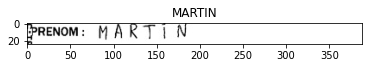

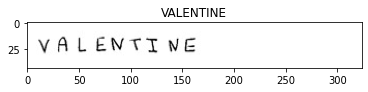

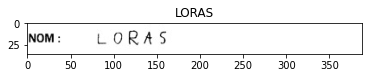

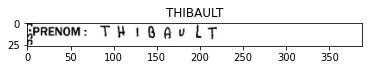

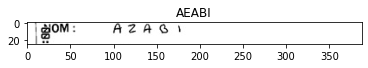

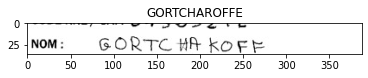

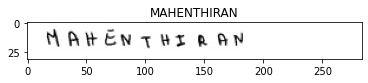

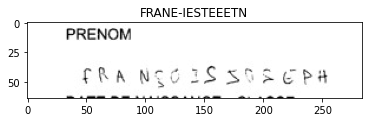

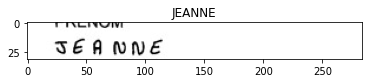

In [49]:
for i in range(5,14):
    img_dir = 'D:/Thirumalai/32053/RCNN&GRU/test/'+test_written_df.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = cv2.resize(image, (256, 32));
    image = tf.keras.utils.normalize(image, axis = 1)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    prediction = model.predict(image.reshape(1, 256, 32, 1))
    decoded_label = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])
    plt.title(num_to_char(decoded_label[0]))
    plt.show()